### Get data

In [161]:
# imports 
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics as tm
from torch import nn

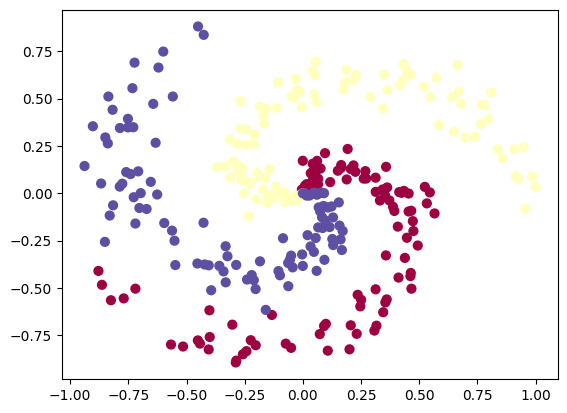

In [162]:
import numpy as np
import matplotlib.pyplot as plt
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.3 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [163]:
RANDOM_SEED = 42

# to tensors and train test split
from sklearn.model_selection import train_test_split
device = "cuda" if pt.cuda.is_available() else "cpu"


X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=RANDOM_SEED)
X_train,X_test, y_train, y_test = pt.tensor(X_train, dtype=pt.float).to(device), pt.tensor(X_test, dtype=pt.float).to(device), pt.tensor(y_train, dtype=pt.float).to(device), pt.tensor(y_test, dtype=pt.float).to(device)

print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)
#print(X_train,X_test, y_train, y_test)


torch.Size([240, 2]) torch.Size([60, 2]) torch.Size([240]) torch.Size([60])


In [164]:
print(X_train.dtype,X_test.dtype, y_train.dtype, y_test.dtype)


torch.float32 torch.float32 torch.float32 torch.float32


In [165]:
pt.manual_seed(42)
pt.cuda.manual_seed(42)
class SpiralModelV0(nn.Module):
    def __init__(self,  hidden_units=5, input_features=2, output_features=1):
        """layers except for first and second"""
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
model_0 = SpiralModelV0(output_features=4).to(device)

In [166]:
loss_fn = nn.CrossEntropyLoss()

optimizer = pt.optim.Adam(params=model_0.parameters(), lr=0.01)

acc_fn = tm.Accuracy("multiclass", num_classes=3)

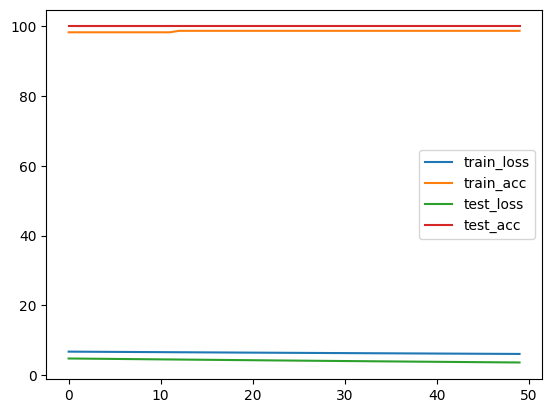

    train_loss        train_acc  test_loss      test_acc
0     6.689990  tensor(98.3333)   4.722099  tensor(100.)
1     6.674902  tensor(98.3333)   4.696362  tensor(100.)
2     6.659890  tensor(98.3333)   4.670721  tensor(100.)
3     6.644955  tensor(98.3333)   4.645177  tensor(100.)
4     6.630096  tensor(98.3333)   4.619730  tensor(100.)
5     6.615312  tensor(98.3333)   4.594374  tensor(100.)
6     6.600600  tensor(98.3333)   4.569118  tensor(100.)
7     6.585963  tensor(98.3333)   4.543956  tensor(100.)
8     6.571397  tensor(98.3333)   4.518890  tensor(100.)
9     6.556901  tensor(98.3333)   4.493924  tensor(100.)
10    6.542479  tensor(98.3333)   4.469053  tensor(100.)
11    6.528125  tensor(98.3333)   4.444278  tensor(100.)
12    6.513842  tensor(98.7500)   4.419600  tensor(100.)
13    6.499627  tensor(98.7500)   4.395019  tensor(100.)
14    6.485481  tensor(98.7500)   4.370539  tensor(100.)
15    6.471400  tensor(98.7500)   4.346149  tensor(100.)
16    6.457387  tensor(98.7500)

In [180]:
from ml_funcs import progress_viewer
pv = progress_viewer()

epochs = 50

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train)
    y_preds = pt.softmax(y_logits, dim=1).argmax(1)
    loss = loss_fn(y_logits, y_train.type(pt.long))
    acc = acc_fn(y_train, y_preds)

    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()

    model_0.eval()

    with pt.inference_mode():
        y_test_logits = model_0(X_test)
        y_test_preds = pt.softmax(y_test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(y_test_logits, y_test.type(pt.long))
        test_acc = acc_fn(y_test, y_test_preds)
    pv.add(loss.item(),acc*100,test_loss.item(), test_acc*100)
pv.show()
print(pv.df)



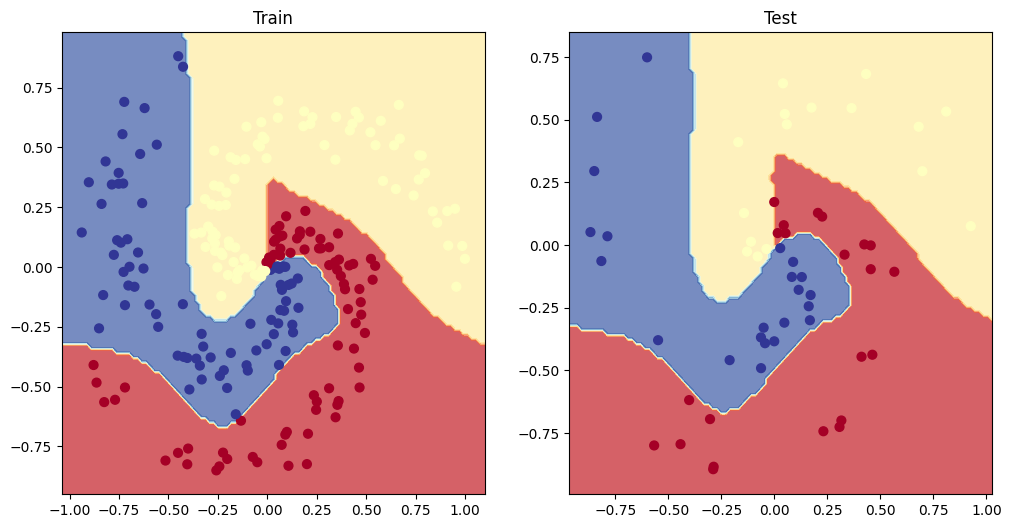

In [181]:
# view
import helper_functions
def view_results(X_train, y_train, X_test, y_test, model):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Train")
    helper_functions.plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1,2,2)
    plt.title("Test")
    helper_functions.plot_decision_boundary(model, X_test, y_test)
view_results(X_train, y_train, X_test, y_test, model_0)